In [161]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import ranking
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
test_file_path = r"U:\LegalAnalytics\BailPrediction\data\preprocessed\full_data_val.json"

In [163]:
with open(test_file_path, 'r', encoding='utf-8') as file:
    test_data = json.load(file)

In [164]:
# Convert test data to a DataFrame with 'facts-and-arguments' and 'judge-opinion' as separate columns
df = pd.DataFrame([{
    'id': entry['id'],
    'district': entry['district'],
    'facts_and_arguments': ' '.join(entry['text'].get('facts-and-arguments', [])),
    'judge_opinion': ' '.join(entry['text'].get('judge-opinion', [])),
    'label': entry['label']
} for entry in test_data])


In [165]:
df = df.head(1000)

In [166]:
df['ranked_sentences'] = df['facts_and_arguments'].apply(lambda text: ranking.process([text])['ranked_sentences'])

In [167]:
df.head(2)

,id,district,facts_and_arguments,judge_opinion,label,ranked_sentences
0,Bail Application_1637_202021-07-20201079,aligarh,"संक्षेप में, प्रथम सूचना रिपोर्ट के अनुसार घटन...",मैंने उभय पक्ष के विद्वान अधिवक्तागण के तर्क स...,1,[संक्षेप में प्रथम सूचना रिपोर्ट के अनुसार घटन...
1,Bail Application__1727_202028-10-20205015,etah,प्रार्थनापत्र प्रस्तुत किया गया है। अभियुक्त <...,जमानत प्रार्थनापत्र <नाम> प्रार्थीगण/अभियुक्तग...,1,"[प्रार्थनापत्र प्रस्तुत किया गया है, अभियुक्त..."


In [168]:
# Initialize an empty list to store bail scores
bail_scores = []
prediction = []

# Define the maximum length for input truncation (adjust as needed for your model)
max_length = 512

# Loop through each row, join ranked sentences, and predict the bail score one by one
for ranked_sentences in df['ranked_sentences']:
    if isinstance(ranked_sentences, list):
        joined_sentences = ' '.join(ranked_sentences)[:max_length]  # Truncate to the maximum length
        bail_score = ranking.predict_bail_score([joined_sentences])[0]  # Pass as a single string
        bail_scores.append(bail_score)
        prediction.append(1 if bail_score > 50 else 0)

In [169]:
df['bail_score'] = bail_scores
df['prediction'] = prediction

Confusion Matrix:


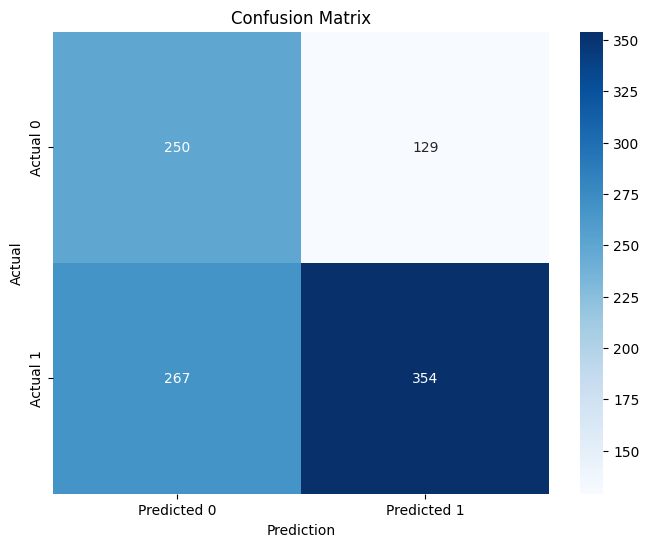

In [170]:
print("Confusion Matrix:")
cm = confusion_matrix(df['label'], df['prediction'])
# Plot the confusion matrix 
plt.figure(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [171]:
print("\nClassification Report:")
print(classification_report(df['label'], df['prediction']))


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.66      0.56       379
           1       0.73      0.57      0.64       621

    accuracy                           0.60      1000
   macro avg       0.61      0.61      0.60      1000
weighted avg       0.64      0.60      0.61      1000



In [172]:
print("\nAccuracy Score:")
print(accuracy_score(df['label'], df['prediction']))


Accuracy Score:
0.604
